In [ ]:
#%pip install google-cloud-bigquery
#%pip install db-dtypes
#%pip install pandas-gbq

In [208]:
query = f"""
select uoe.* EXCEPT(`inventory_item_id`, `product_id`),
iv.id `inventory_item_id`,
iv.product_id,
iv.product_category `category`,
iv.product_brand `brand`,
iv.product_name,
CAST(iv.created_at AS DATE) `inventory_created_at`,
CAST(sold_at AS DATE) `inventory_sold_at`,
iv.cost
from
(select uo.*,
oi.id `order_items_id`,
oi.product_id,
oi.inventory_item_id,
oi.status,
oi.sale_price,
CAST(oi.created_at AS DATE) `order_created_at`,
e.session_id,
e.sequence_number,
e.user_id `login_user_id`,
CAST(e.created_at AS DATE) `sess_created_at`,
e.traffic_source `sess_traffic_source`,
e.uri,
e.event_type,
e.ip_address,
e.state `sess_state`,
e.city `sess_city`,
from
(select u.id `user_id`,
u.age,
u.gender,
u.state `account_state`,
u.city `account_city`,
u.country `account_country`,
u.latitude,
u.longitude,
u.traffic_source `account_traffic_source`,
CAST(u.created_at AS DATE) `account_created_at`,
o.order_id,
FROM `org_data.users` u
FULL OUTER JOIN `org_data.orders` o
on o.user_id=u.id) uo
FULL OUTER JOIN `org_data.order_items` oi
on oi.user_id=uo.user_id and oi.order_id=uo.order_id
FULL OUTER JOIN `org_data.events` e
on uo.user_id=e.user_id and e.created_at=oi.created_at and e.event_type='purchase'
where (oi.shipped_at >= oi.created_at) or (e.created_at is not null and oi.created_at is null) or (oi.created_at is null and uo.account_created_at is not null)
) uoe
FULL OUTER JOIN `org_data.inventory_items` iv
on iv.id=uoe.inventory_item_id
"""

In [209]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./looker-ecommerce-e30fc40090ce.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 조회 예시 쿼리문 
# FROM절 프로젝트명.데이터셋명.테이블명
query = query
check = client.query(query).to_dataframe()
check

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,...,sess_state,sess_city,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost
0,73890,40,F,California,San Francisco,United States,37.795407,-122.422234,Search,2023-05-09,...,None,None,363366,5672,Pants & Capris,Eddie Bauer,Eddie Bauer Curvy Blakely Legend Wash Pants,2023-02-03,NaT,29.28835
1,17088,21,M,Jiangsu,Nanjing,China,31.943910,118.708140,Search,2019-11-09,...,None,None,<NA>,<NA>,None,None,None,NaT,NaT,NaN
2,35074,31,M,Mississippi,Meridian,United States,32.271808,-88.588992,Facebook,2023-05-04,...,None,None,171684,28534,Accessories,Oakley,Oakley Flak Jacket XLJ Replacement Lenses,2023-03-07,NaT,22.77000
3,25732,43,M,Guangdong,Beijing,China,23.011909,113.816281,Search,2022-11-14,...,None,None,125940,23992,Outerwear & Coats,Alpha Industries,Injector (183112),2023-08-20,NaT,71.28000
4,76554,48,M,Bretagne,Janzé,France,47.972114,-1.494561,Organic,2020-11-11,...,None,None,<NA>,<NA>,None,None,None,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848087,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,381869,170,Tops & Tees,Ralph Lauren,Ralph Lauren Sport Women Lightweight V-Neck T-...,2023-10-25,2023-12-22,15.81435
2848088,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,27448,751,Tops & Tees,Splendid,Splendid Women's Long Sleeve Collar Top Shirt,2021-10-14,NaT,48.92800
2848089,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,300243,751,Tops & Tees,Splendid,Splendid Women's Long Sleeve Collar Top Shirt,2022-09-22,NaT,48.92800
2848090,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,302741,153,Tops & Tees,Under Armour,Women's UA EVO ColdGearÂ® Longsleeve Mock Tops...,2022-06-07,NaT,26.33715


In [173]:
check.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771595 entries, 0 to 2771594
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   user_id                 112960 non-null   float64
 1   age                     112960 non-null   float64
 2   gender                  112960 non-null   object 
 3   account_state           112960 non-null   object 
 4   account_city            111840 non-null   object 
 5   account_country         112960 non-null   object 
 6   latitude                112960 non-null   float64
 7   longitude               112960 non-null   float64
 8   account_traffic_source  112960 non-null   object 
 9   account_created_at      112960 non-null   object 
 10  order_id                93004 non-null    float64
 11  order_items_id          93004 non-null    float64
 12  status                  93004 non-null    object 
 13  sale_price              93004 non-null    float64
 14  or

In [218]:
# check.to_csv('./looker.csv', index=False)

In [212]:
df = check.copy()

카이 제곱 검정
- 신규 유저 (실험군) vs 기존 유저 (대조군)
1. 개인 정보: 성별, 연령대, 국가, 유입경로, `→ same` @하늘
    - 구매 전환율 (1번 이상 결제), retention (2번 이상 결제) `→ diff` @영아
2. 구매 상품: product_id, category, brand, … `→ same` @지은
    - top 3

In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

In [3]:
df = pd.read_csv('./looker.csv')

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_61371/330098794.py:1: DtypeWarning: Columns (2,3,4,5,8,9,12,14,15,18,19,20,21,22,23,24,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./looker.csv')


In [4]:
# 형변환
def convert_type(df):
    for col in df.columns:
        if '_at' in col:    # 시간 데이터
            df = df.assign(**{col:pd.to_datetime(df[col])})
            print('[+] {0:<30} >>> datetime'.format(col))
        elif '_id' in col:  # id 컬럼 -> obj형으로
            df = df.assign(**{col:df[col].astype('object')})
            print('[+] {0:<30} >>> object'.format(col))
    return df

In [176]:
df = convert_type(df)

[+] user_id                        >>> object
[+] account_created_at             >>> datetime
[+] order_id                       >>> object
[+] order_items_id                 >>> object
[+] order_created_at               >>> datetime
[+] session_id                     >>> object
[+] login_user_id                  >>> object
[+] sess_created_at                >>> datetime
[+] inventory_item_id              >>> object
[+] product_id                     >>> object
[+] inventory_created_at           >>> datetime
[+] inventory_sold_at              >>> datetime


In [9]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771595 entries, 0 to 2771594
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   user_id                 112960 non-null   float64
 1   age                     112960 non-null   float64
 2   gender                  112960 non-null   object 
 3   account_state           112960 non-null   object 
 4   account_city            111840 non-null   object 
 5   account_country         112960 non-null   object 
 6   latitude                112960 non-null   float64
 7   longitude               112960 non-null   float64
 8   account_traffic_source  112960 non-null   object 
 9   account_created_at      112960 non-null   object 
 10  order_id                93004 non-null    float64
 11  order_items_id          93004 non-null    float64
 12  status                  93004 non-null    object 
 13  sale_price              93004 non-null    float64
 14  or

In [219]:
df.groupby('account_created_at').agg({'user_id':'nunique'}).tail(10).style.background_gradient()

,user_id
account_created_at,
2024-01-07 00:00:00,37
2024-01-08 00:00:00,31
2024-01-09 00:00:00,41
2024-01-10 00:00:00,35
2024-01-11 00:00:00,331
2024-01-12 00:00:00,364
2024-01-13 00:00:00,368
2024-01-14 00:00:00,345
2024-01-15 00:00:00,363


In [220]:
# 실험군: 2024 신규 유입 유저
treatment = df[df.account_created_at >= '2024-01-11'].copy()

In [221]:
# 대조군: 기존 유저
#control = df[df.account_created_at.dt.year==2023].copy()   # 2023년 가입 유저
control = df[df.account_created_at < '2024-01-11'].copy()

In [222]:
print(
    f'전체 유저 수 : {df.user_id.nunique(dropna=True)}명\n\
실험군 (treatment) : {treatment.user_id.nunique()}명\n\
대조군 (control) : {control.user_id.nunique()}명'
    )

전체 유저 수 : 75608명
실험군 (treatment) : 2108명
대조군 (control) : 73500명


In [223]:
chk_order = df.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

<Axes: ylabel='Frequency'>

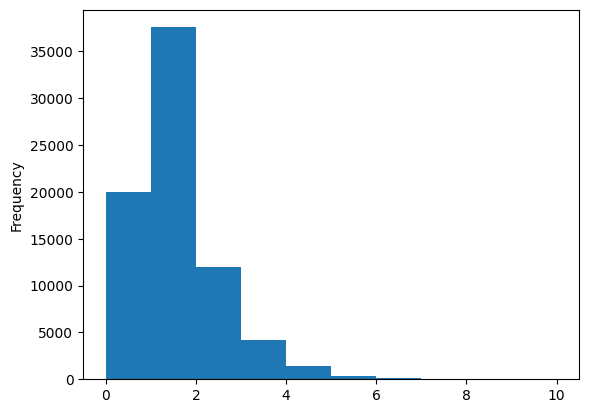

In [224]:
chk_order['order_items_id'].plot.hist()

In [225]:
chk_order_test = treatment.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()
chk_order_control = control.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

In [226]:
test_order_0 = len(chk_order_test[chk_order_test.order_items_id == 0])
test_order_purchase = len(chk_order_test[chk_order_test.order_items_id != 0])
test_order_repurchase = len(chk_order_test[chk_order_test.order_items_id > 1])

In [227]:
control_order_0 = len(chk_order_control[chk_order_control.order_items_id == 0])
control_order_purchase = len(chk_order_control[chk_order_control.order_items_id != 0])
control_order_repurchase = len(chk_order_control[chk_order_control.order_items_id > 1])

### 구매율

In [228]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
non_purchase = [test_order_0, control_order_0]  # A와 B의 구매 안 한 유저 수

## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, non_purchase], columns=['treatment', 'control'], index=['purchase', 'non_purchase'])

## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = stats.chi2_contingency([purchase, non_purchase])

## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'non_purchase'])

print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )

  
[Chi-square Analysis Result Report]
Chi-square: 0.26
P-value: 0.61
--------------------------
Expected Values
                treatment       control
purchase      1551.613797  54100.386203
non_purchase   556.386203  19399.613797
--------------------------
Observed Values
              treatment  control
purchase           1541    54111
non_purchase        567    19389
 


In [229]:
# 실험군
1541 / (1541 + 567)

0.7310246679316889

In [230]:
# 대조군
54111 / (54111 + 19389)

0.736204081632653

P-value가 0.72로 0.05보다 크다 -> 두 그룹의 차이가 없다... => 심지어 구매전환율이 기존유저가 좀 더 크다....?

### 재구매율

In [231]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
repurchase = [test_order_repurchase, control_order_repurchase]  # A와 B의 재구매한 유저 수
 
## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, repurchase], columns=['treatment', 'control'], index=['purchase', 'repurchase'])
 
## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = stats.chi2_contingency([purchase, repurchase])
 
## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'repurchase'])
 
print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )

  
[Chi-square Analysis Result Report]
Chi-square: 0.5
P-value: 0.48
--------------------------
Expected Values
              treatment       control
purchase    1555.094478  54096.905522
repurchase   504.905522  17564.094478
--------------------------
Observed Values
            treatment  control
purchase         1541    54111
repurchase        519    17550
 


In [232]:
519 / (1541 + 519)

0.2519417475728155

In [233]:
17550 / (17550 + 54111)

0.24490308536023778

P-value가 0.29로 0.05보다 크다 -> 두 그룹의 차이가 없다... => 재구매율은 신규 유저가 좀 더 크다

### 가입 시점 ~ 첫 결제일

In [234]:
first_order = df.groupby('user_id').order_created_at.min().to_frame().merge(df[['user_id', 'account_created_at']], on='user_id', suffixes=('', '_first'))

In [235]:
first_order = convert_type(first_order)

[+] user_id                        >>> object
[+] order_created_at               >>> datetime
[+] account_created_at             >>> datetime


In [236]:
first_order = first_order.assign(order_diff=first_order['order_created_at'] - first_order['account_created_at'])
first_order = first_order.assign(order_diff=first_order.order_diff.dt.days)

In [237]:
first_order.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102365 entries, 0 to 102364
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             102365 non-null  object        
 1   order_created_at    82409 non-null   datetime64[ns]
 2   account_created_at  102365 non-null  datetime64[ns]
 3   order_diff          82409 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 3.1+ MB


In [238]:
# 실험군: 2024 신규 유입 유저 / 대조군: 기존 유저
first_order.loc[first_order.account_created_at >= '2024-01-11', 'grp'] = 'treatment'
first_order.loc[first_order.account_created_at < '2024-01-11', 'grp'] = 'control'

In [239]:
var_test = np.var(first_order[first_order.grp=='treatment'].order_diff)
var_ctrl = np.var(first_order[first_order.grp=='control'].order_diff)

print('지불 금액의 분산: 실험군 {:.2f}일 vs 대조군 {:.2f}일'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
else:
    print('분산이 같으므로, Student\'s t-test')

지불 금액의 분산: 실험군 0.79일 vs 대조군 136395.04일
분산이 2배 이상 차이나므로, Welch's t-test


In [240]:
t_stat, p_val = stats.ttest_ind(first_order[first_order.grp=='treatment'].order_diff.dropna(), 
                                first_order[first_order.grp=='control'].order_diff.dropna(),
                                equal_var=False)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: -291.94615442265354    p-value: 0.0
두 그룹이 차이가 있다.


### 가입 시점 ~ 두 번째 결제일

In [241]:
# 2번 이상 구매한 유저 대상
ret = df.groupby('user_id').order_id.count().to_frame()
ret_user_list = ret[ret.order_id >= 2].index

In [242]:
second_order = df[df.user_id.isin(ret_user_list)].groupby('user_id').order_created_at.apply(lambda x: sorted(x)[1]).to_frame()
second_order = second_order.merge(df[['user_id', 'account_created_at']], on='user_id', how='left').drop_duplicates()

In [243]:
second_order = convert_type(second_order)

[+] user_id                        >>> object
[+] order_created_at               >>> datetime
[+] account_created_at             >>> datetime


In [244]:
second_order = second_order.assign(order_diff=second_order['order_created_at'] - second_order['account_created_at'])
second_order = second_order.assign(order_diff=second_order.order_diff.dt.days)

In [245]:
second_order.loc[second_order.account_created_at >= '2024-01-11', 'grp'] = 'treatment'
second_order.loc[second_order.account_created_at < '2024-01-11', 'grp'] = 'control'

In [246]:
var_test = np.var(second_order[second_order.grp=='treatment'].order_diff)
var_ctrl = np.var(second_order[second_order.grp=='control'].order_diff)

print('지불 금액의 분산: 실험군 {:.2f}일 vs 대조군 {:.2f}일'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
else:
    print('분산이 같으므로, Student\'s t-test')

지불 금액의 분산: 실험군 1.32일 vs 대조군 168739.93일
분산이 2배 이상 차이나므로, Welch's t-test


In [247]:
t_stat, p_val = stats.ttest_ind(second_order[second_order.grp=='treatment'].order_diff, 
                                second_order[second_order.grp=='control'].order_diff,
                                equal_var=False)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: -170.07671223788716    p-value: 0.0
두 그룹이 차이가 있다.


### 지불 금액

In [248]:
chk_total_purchase = df.groupby('user_id').agg({'sale_price':'sum'}).reset_index()

<Axes: ylabel='Frequency'>

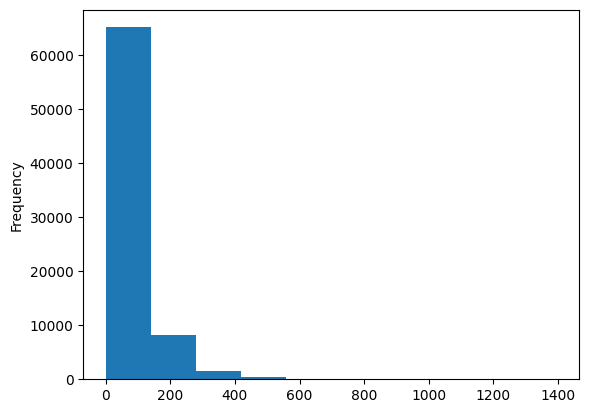

In [249]:
chk_total_purchase['sale_price'].plot.hist()

In [250]:
print(
    '전체 유저의 평균 지불 금액: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.median(chk_total_purchase['sale_price']), 
        np.mean(chk_total_purchase['sale_price']))
)

전체 유저의 평균 지불 금액: 중앙값 36.95 | 평균값 65.17


In [251]:
print(
    '1인당 평균 지불 금액: 실험군 ${:.2f} vs 대조군 ${:.2f}'.format(
        np.mean(treatment.groupby('user_id').agg({'sale_price':'sum'})), 
        np.mean(control.groupby('user_id').agg({'sale_price':'sum'})))
)

1인당 평균 지불 금액: 실험군 $68.21 vs 대조군 $65.09


In [252]:
print(
    '제품단가: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.nanmedian(df.groupby('product_name').agg({'sale_price':'mean'})), 
        np.mean(df.groupby('product_name').agg({'sale_price':'mean'})))
)

제품단가: 중앙값 39.99 | 평균값 59.63


In [253]:
var_test = np.var(treatment.groupby('user_id').agg({'sale_price':'sum'}))[0]
var_ctrl = np.var(control.groupby('user_id').agg({'sale_price':'sum'}))[0]

print('지불 금액의 분산: 실험군 ${:.2f} vs 대조군 ${:.2f}'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
else:
    print('분산이 같으므로, Student\'s t-test')

지불 금액의 분산: 실험군 $9393.79 vs 대조군 $8190.18
분산이 같으므로, Student's t-test


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_61371/3112985805.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_test = np.var(treatment.groupby('user_id').agg({'sale_price':'sum'}))[0]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will r

In [254]:
cum_purchase_treatment = treatment.groupby('user_id').agg({'sale_price':'sum'})
cum_purchase_control = control.groupby('user_id').agg({'sale_price':'sum'})

In [255]:
t_stat, p_val = stats.ttest_ind(cum_purchase_treatment, cum_purchase_control,
                                equal_var=False)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: [1.45844521]    p-value: [0.14485973]
두 그룹이 차이가 없다.


### 특정 product 구매
- 2024년 1월 11일부터 판매량이 많은 제품 top 5
- 이 제품을 구매한 유저 수 vs 구매 안한 유저 수

In [256]:
product_top5 = df[df.order_created_at >= '2024-01-11'].product_name.value_counts()[:5].index

In [257]:
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i,product in enumerate(product_top5, start=1):

    test = treatment[treatment.product_name==product].user_id.nunique()
    ctrl = control[control.product_name==product].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_product = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_product = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_product, unpurchase_product], columns=['treatment', 'control'], index=[f'purchase_{product}', f'unpurchase_{product}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = stats.chi2_contingency([purchase_product, unpurchase_product])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{product}', f'unpurchase_{product}'])

    print(
      'Product {}: {}'.format(i, product)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: Boconi Collins Calf Billfold
Chi-square: 10.92
P-value: 0.0
--------------------------
Expected Values
                                           treatment       control
purchase_Boconi Collins Calf Billfold    1555.094478  54096.905522
unpurchase_Boconi Collins Calf Billfold   504.905522  17564.094478
--------------------------
Observed Values
                                         treatment  control
purchase_Boconi Collins Calf Billfold            2        4
unpurchase_Boconi Collins Calf Billfold       2106    73496
Product 2: 2 PC. Ladies Lace Babydoll Set - One Size - Black/Pink
Chi-square: 52.62
P-value: 0.0
--------------------------
Expected Values
                                                      treatment       control
purchase_2 PC. Ladies Lace Babydoll Set - One S...  1555.094478  54096.905522
unpurchase_2 PC. Ladies Lace Babydoll Set - One...   504.905522  17564.094478
---------------

P-value가 0.0로 0.05보다 작다 -> 두 그룹의 차이가 있다 => 신규 유저가 해당 카테고리를 더 샀다

In [258]:
# 해당 제품들의 첫 입고 시기
for i, product in enumerate(product_top5, start=1):
    print('{}. {:<70}: {}'.format(
        i,
        product,
        df[df.product_name==product].inventory_created_at.min()
    ))

1. Boconi Collins Calf Billfold                                          : 2019-12-11 00:00:00
2. 2 PC. Ladies Lace Babydoll Set - One Size - Black/Pink                : 2019-04-11 00:00:00
3. Port Authority K321 Interlock Knit Mock Turtleneck                    : 2020-01-30 00:00:00
4. Burnside Men's Bedrock Plaid Woven Short                              : 2019-08-25 00:00:00
5. Volcom Men's Nova Modern Straight Leg Fit                             : 2020-01-27 00:00:00


=> 입고 시기는 과거였어도, 결국 해당 제품을 구매한 유저가 4명 ~ 8명인데 두 그룹이 다르다고 할 수 있을까....?ㅜㅜ

In [259]:
category_top5 = df[df.order_created_at >= '2024-01-11'].category.value_counts()[:5].index
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i, category in enumerate(category_top5, start=1):

    test = treatment[treatment.category==category].user_id.nunique()
    ctrl = control[control.category==category].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_category = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_category = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_category, unpurchase_category], columns=['treatment', 'control'], index=[f'purchase_{category}', f'unpurchase_{category}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = stats.chi2_contingency([purchase_category, unpurchase_category])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{category}', f'unpurchase_{category}'])

    print(
      'Product {}: {}'.format(i, category)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: Intimates
Chi-square: 1.5
P-value: 0.22
--------------------------
Expected Values
                        treatment       control
purchase_Intimates    1555.094478  54096.905522
unpurchase_Intimates   504.905522  17564.094478
--------------------------
Observed Values
                      treatment  control
purchase_Intimates          175     5558
unpurchase_Intimates       1933    67942
Product 2: Fashion Hoodies & Sweatshirts
Chi-square: 2.54
P-value: 0.11
--------------------------
Expected Values
                                            treatment       control
purchase_Fashion Hoodies & Sweatshirts    1555.094478  54096.905522
unpurchase_Fashion Hoodies & Sweatshirts   504.905522  17564.094478
--------------------------
Observed Values
                                          treatment  control
purchase_Fashion Hoodies & Sweatshirts          165     5078
unpurchase_Fashion Hoodies & Sweatshirt